# Logistic Regression Example
Using the Pima Indian Diabetes dataset
https://www.kaggle.com/uciml/pima-indians-diabetes-database

## Import Python Packages

In [1]:
#Data Manipulation packages

import pandas as pd
import numpy as np

#Machiene Learning packages
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#viz packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Loading Data

In [2]:
col_names=['pregnant','glucose','bp','skin','insulin','bmi','pedigree','age','label']
#load in csv

pima=pd.read_csv("diabetes.csv", header=None, skiprows=[0], names=col_names)

In [3]:
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
## Data Exploration & Cleaning

In [5]:
print('# rows = {}, # columns = {}'.format(pima.shape[0], pima.shape[1]))
pima.describe()

# rows = 768, # columns = 9


,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Are there any missing values?

In [6]:
print(pima.isnull().sum().sum())

0


### Replace Missing Values 

In [7]:
# Replace categorical missing with missing category 
#df[df.columns[df.dtypes == 'object']] = df[df.columns[df.dtypes == 'object']].fillna(value='missing')

#Replace with zero if  missing means zero
#df['xxx'].fillna(0,inplace=True)

#Replace remaining numerical missings with median
#df.fillna(df.median(), inplace=True))


### Outlier Detection & Removal

For continous numeric variables, it is worth excluding outlying data points that might otherwise skew the learning of our model later.

A standard way to do this is to use the 6-sigma idea: for a normal distribution (assumption!), 99% of the data should be within +- 3 standard deviations. So anything outside of 6 deviations should definitely be an outlier.

<img src="normal_distribution.PNG">

In [8]:
# Find numeric values
numeric_cols = pima.columns[pima.dtypes != 'object'].tolist()

# Don't consider binary variables
for col in numeric_cols:
    if (pima[col].min() == 0) and (pima[col].max() == 1):
        numeric_cols.remove(col)

# Calculate the means and standard deviations
means = pima[numeric_cols].mean()
stddevs = pima[numeric_cols].std()

# Find out how many values are outliers
sigma = 6
outlier_percs = []
contains_outlier_any_col = np.zeros([len(pima), ]).astype(bool)
for col in numeric_cols:
    outlier = (pima[col] > means[col] + sigma * stddevs[col]) | (pima[col] < means[col] - sigma * stddevs[col])
    contains_outlier_any_col = contains_outlier_any_col | outlier
    outlier_percs.append(100 * sum(outlier) / len(outlier))
    
# Assemble results into a dataframe
outliers_df = pd.DataFrame(
    {'Column': numeric_cols, 'Outlier percentage': outlier_percs}
).sort_values(by='Outlier percentage', ascending=False)

# Total percentage of outliers
print('% of rows with an outlier = {:.2f}%'.format(100 * sum(contains_outlier_any_col) / len(contains_outlier_any_col)))

% of rows with an outlier = 0.13%


### Remove outliers

In [9]:
pima = pima[~contains_outlier_any_col]

Validate features

In [10]:
#is age positive?

def age_positive(ls):
    for i in ls:
        if i < 0:
            return False
    return True

age_positive(pima.age)

True

## Fitting the model

Going to try and predict whether someone has diabetes based on this data

### Split out target and features

In [11]:
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
X = pima[feature_cols] # Features
y = pima.label # Target variable

### Create training and testing sets

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

### Check target distribution

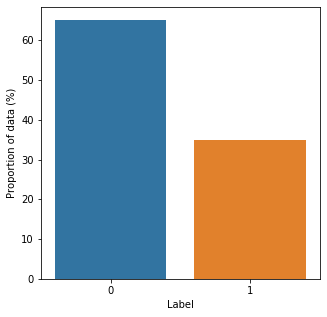

In [13]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
counts = 100 * y_train.value_counts() / len(y_train)
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xlabel('Label')
ax.set_ylabel('Proportion of data (%)')
plt.show()

### Undersampling Target

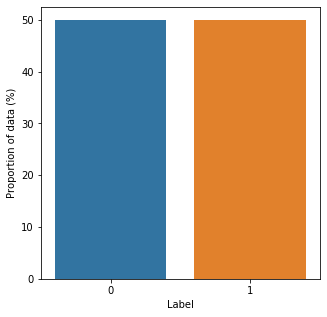

In [14]:
# Class count
count_class_0, count_class_1 = y_train.value_counts()

# Divide by class
y_class_0 = y_train[y_train== 0]
y_class_1 = y_train[y_train== 1]

#undersample 0
y_class_0_under = y_class_0.sample(count_class_1)

y_train_sampled=pd.concat([y_class_0_under, y_class_1], axis=0)

#plot undersampled target
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
counts = 100 * y_train_sampled.value_counts() / len(y_train_sampled)
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xlabel('Label')
ax.set_ylabel('Proportion of data (%)')
plt.show()

### Model Development and Prediction

In [15]:
# instantiate the model 
logreg = LogisticRegression()

# fit the model with train data
logreg.fit(X_train,y_train)

#apply model to test data
y_pred=logreg.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Model Evaluation

Model evaluation using Confusion Matrix

In [16]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[133,  18],
       [ 34,  46]], dtype=int64)

Visualise Confusion Matrx

Text(0.5, 257.44, 'Predicted label')

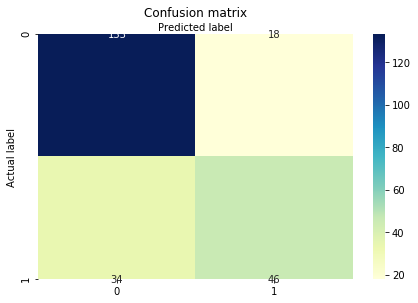

In [17]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Confusion Matrix Evaluation Metrics

Precision: how often the prediction is correct

Recall: what proportion of observations have been correctly assigned

In [18]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7748917748917749
Precision: 0.71875
Recall: 0.575


ROC curve

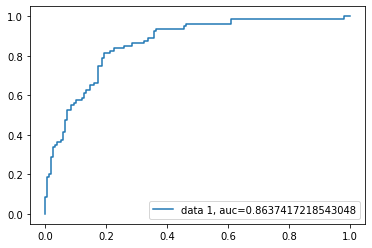

In [19]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Feature importance

In [20]:
print(logreg.coef_)

[[ 1.08873416e-01 -1.22312990e-04  8.44249651e-02  1.56279087e-02
   3.28447050e-02 -1.51115200e-02  8.96533066e-01]]


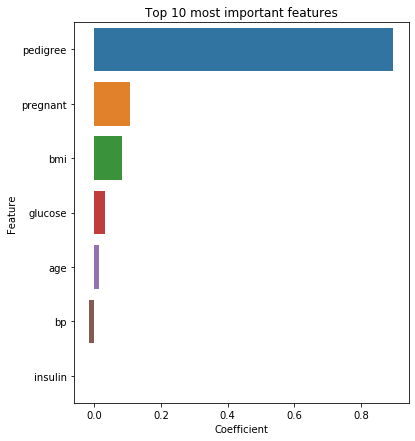

In [21]:
coefficients_df = pd.DataFrame({'Feature': X_test.columns, 'Coefficient': logreg.coef_[0]})
coefficients_df['Coefficient magnitude'] = coefficients_df['Coefficient'].abs()
top_10 = coefficients_df.sort_values(by='Coefficient magnitude', ascending=False)[:10]

fig, ax = plt.subplots(1, 1, figsize=[6, 7])
sns.barplot(x=top_10['Coefficient'], y=top_10['Feature'])
ax.set_title('Top 10 most important features')
plt.show()